In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

import cPickle as pickle

# Goal: predict what type of crime happened in SF neighborhoods
Sources of data: SFPD crime incidents record from 2016 (current year)

In [47]:
#read pickle file saved from all previous work
crime2016 = pd.read_pickle('../dataset/crime2016_1121.pkl')

In [2]:
#data cleaning and munging
#lower case the columns name
#crime2016 = pd.read_csv('/SFPD2016.csv')
crime2016.columns = crime2016.columns.str.lower()

In [ ]:
#get the specific addresses happened at each crime 
from geopy.geocoders import get_geocoder_for_service
geoservice = get_geocoder_for_service('Nominatim')

def reverse_geo(geolocations):
    geolocations = geolocations.apply(lambda x: eval(x))
    lst = geolocations.apply(lambda x: geoservice.reverse(Nominatim(timeout=20), x))
    addresses = lst.apply(lambda x: x.address)
    return addresses

## below is the example displaying how I run and get the specific address for each crime

In [ ]:
#save time, drop the duplicated geolocations that consist of latitude and logitude from 'Location' column
unique = df_geo.drop_duplicates(subset='location')
uni_loc = pd.DataFrame(unique['location'])
uni_loc1000_2000 = uni_loc[1000:2000]

#in order to prevent from blocking from the service, run 1000 geolocation each time
uni_loc1000_2000_series = reverse_geo(uni_loc1000_2000['location'])
with open('../geo_reserve/uni_loc1000_2000_series.pkl', 'wb') as handle:
    pickle.dump(uni_loc1000_2000_series, handle)

with open('../geo_reserve/uni_loc1000_2000_series.pkl', 'rb') as handle:
    geo1000_2000 = pickle.load(handle)

In [ ]:
#all the specific addresses concatenate together
geo = pd.concat([geo0_1000,geo1000_2000,geo2000_3000,geo3000_4000,geo4000_5000,geo5000_5500,geo5500_6500,geo6500_7500,\
               geo7500_8500,geo8500_9500,geo9500_10500,geo10500_11500,geo11500_12500,geo12500_13500,\
               geo13500_14500,geo14500_15500,geo15500_16500,geo16500])
uni_loc['address'] = geo

In [ ]:
#fill in the addresses into the original dataframe
crime2016 = crime2016.merge(uni_loc, how='inner', on='location')

In [ ]:
#all the neighborhoods in crime dataset
crime_neighborhood = ['West SoMa', 'Sunset District', 'Western Addition', 'Seacliff', 'Mission District',\
                'Nob Hill', 'Cow Hollow', 'Financial District', 'Potrero Hill',  'West Portal', 'Castro District',\
                'Ingleside', 'Haight-Ashbury', 'Inner Sunset', 'North Beach', 'North of Panhandle', 'Marina District',\
                'Russian Hill', 'Northeast Waterfront Historic District', 'Japantown', 'Cole Valley', 'Mission Creek',\
                'Lower Pacific Heights', 'Crocker-Amazon', 'Noe Valley', 'Richmond District', 'Presidio Terrace',\
                'Telegraph Hill', 'South Beach', 'Saint Francis Wood', 'Forest Hill', 'Dogpatch', 'Pacific Heights',\
                'Mission Bay', 'Daly City', 'Fisherman\'s Warf', 'Bayshore', 'Bayview District', 'Presidio Heights',\
                'Hayes Valley', 'Chinatown', 'South of Market', 'Parkmerced']

In [ ]:
#create a function to get the neighborhood for each crime indicidents
def crime_neighborhood_mapping(address):
    for i in crime_neighborhood:
        if i in address:
            return i

crime2016['neighborhood'] = crime2016['address'].apply(lambda x: crime_neighborhood_mapping(x))

## data feature engineering

In [ ]:
#create columns for the time that each crime incident happened
crime2016['new_time'] = crime2016['date'] + ' ' +crime2016['time']
crime2016['new_time'] = pd.to_datetime(crime2016['new_time'])
crime2016['hour'] = crime2016['new_time'].apply(lambda x: x.hour)
crime2016['day'] = crime2016['new_time'].apply(lambda x: x.day)
crime2016['month'] = crime2016['new_time'].apply(lambda x: x.month)
crime2016['year'] = crime2016['new_time'].apply(lambda x: x.year)

### check what hour did the crime incident happend

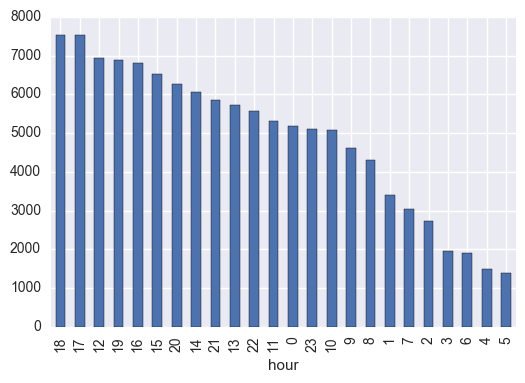

In [8]:
crime2016.groupby('hour')['category'].count().sort_values(ascending=False).plot(kind='bar')

### based on the results, create columns for morning, afternoon, and night time features

In [ ]:
def feature_day_to_night(df):
    crime2016['morning'] = np.where((crime2016.hour>3) & (crime2016.hour < 12), 1, 0)
    crime2016['afternoon'] = np.where((crime2016.hour>11) & (crime2016.hour < 20), 1, 0)
    crime2016['night'] = np.where((crime2016.hour > 19) | (crime2016.hour < 4), 1, 0)
    return df

crime2016 = crime2016.apply(feature_day_to_night)

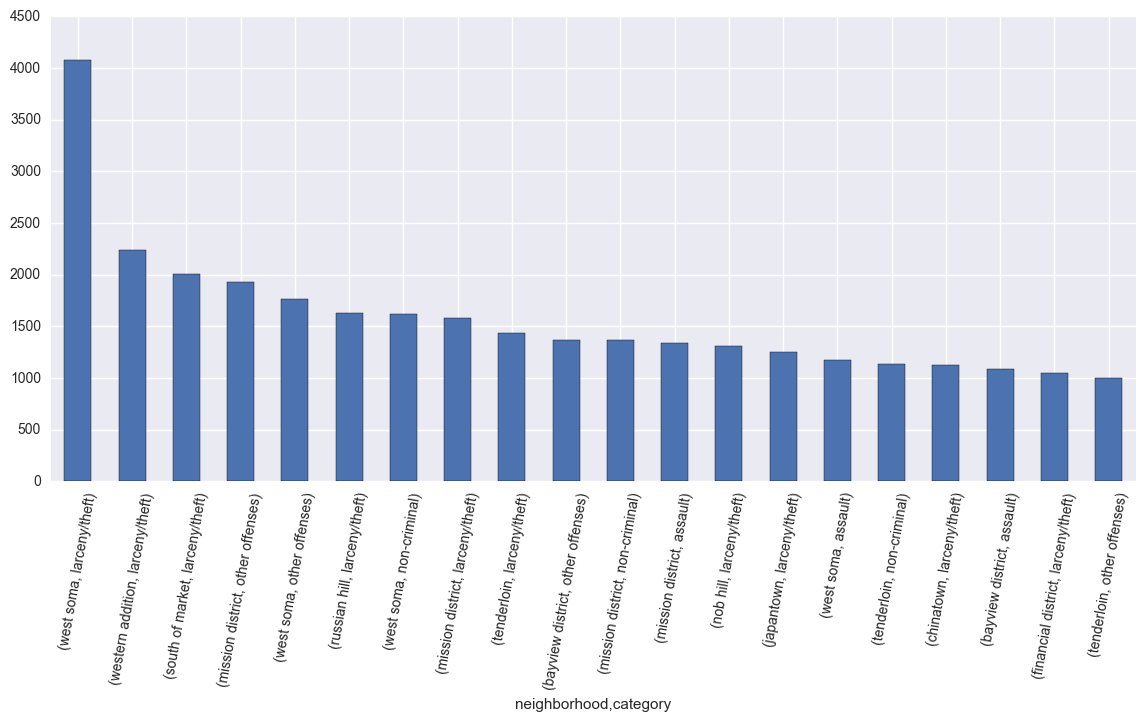

In [19]:
#investigate which category of crime happended most frequently in the neighborhoods
a = crime2016.groupby(['neighborhood', 'category'])['neighborhood'].count().sort_values(ascending=False)
a.head(20).plot('bar', figsize=(14,6))
plt.xticks(rotation=80)
plt.show()

### Larceny Theft is the most frequent one. Now let's see what kinds of crimes did the police recorded

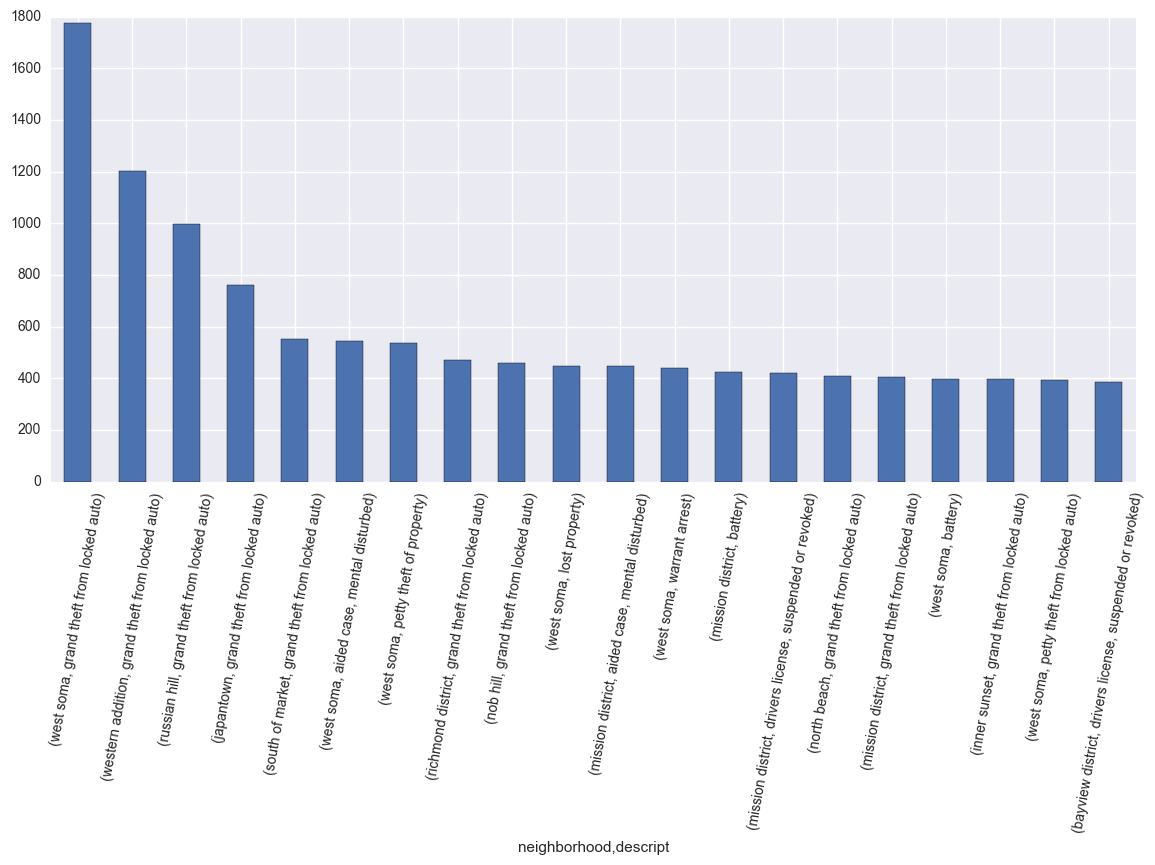

In [14]:
b = crime2016.groupby(['neighborhood', 'descript'])['neighborhood'].count().sort_values(ascending=False)
b.head(20).plot('bar', figsize=(14,6))
plt.xticks(rotation=80)
plt.show()

### grand theft from locked auto is the most frequent type of crime, break them down into different features based on what time it happened (morning, afternoon, night?)

In [51]:
crime2016.shape

(117201, 26)

In [46]:
resolution = crime2016[crime2016['resolution'] == 'none']
resolution[(resolution['descript']=='grand theft from locked auto') & (resolution['morning'] == 1)]

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address_x,x,...,hour,day,month,year,morning,afternoon,night,auto_theft_morning,auto_theft_afternoon,auto_theft_night
216,166020766,larceny/theft,grand theft from locked auto,monday,01/18/2016,09:13,bayview,none,0 block of dorman av,-122.402879,...,9,18,1,2016,1,0,0,1,0,0
252,160008754,larceny/theft,grand theft from locked auto,monday,01/04/2016,10:50,richmond,none,5300 block of geary bl,-122.476719,...,10,4,1,2016,1,0,0,1,0,0
253,160581926,larceny/theft,grand theft from locked auto,tuesday,07/19/2016,10:30,richmond,none,5300 block of geary bl,-122.476719,...,10,19,7,2016,1,0,0,1,0,0
268,166091513,larceny/theft,grand theft from locked auto,wednesday,04/20/2016,11:30,richmond,none,1100 block of 9th av,-122.466504,...,11,20,4,2016,1,0,0,1,0,0
273,160435981,larceny/theft,grand theft from locked auto,saturday,05/28/2016,09:52,richmond,none,1100 block of 9th av,-122.466504,...,9,28,5,2016,1,0,0,1,0,0
331,160589174,larceny/theft,grand theft from locked auto,thursday,07/21/2016,11:52,central,none,500 block of beach st,-122.418111,...,11,21,7,2016,1,0,0,1,0,0
346,166158884,larceny/theft,grand theft from locked auto,wednesday,07/13/2016,10:00,central,none,500 block of beach st,-122.418111,...,10,13,7,2016,1,0,0,1,0,0
347,166159127,larceny/theft,grand theft from locked auto,friday,07/15/2016,11:05,central,none,500 block of beach st,-122.418111,...,11,15,7,2016,1,0,0,1,0,0
720,160020300,larceny/theft,grand theft from locked auto,friday,01/08/2016,09:30,southern,none,800 block of bryant st,-122.403405,...,9,8,1,2016,1,0,0,1,0,0
721,160020946,larceny/theft,grand theft from locked auto,friday,01/08/2016,09:45,southern,none,800 block of bryant st,-122.403405,...,9,8,1,2016,1,0,0,1,0,0


In [113]:
# def auto_theft_cat(df):
    #df['descript']=='grand theft from locked auto' & (resolution['morning'] == 1)
#     df['descript'] = np.where((df['afternoon'] == 1) & (df['descript'] == 'grand theft from locked auto'), 'auto_theft_afternoon')
#     df['descript'] = np.where((df['night'] == 1) & (df['descript'] == 'grand theft from locked auto'), 'auto_theft_night')
#     return df


n = crime2016.category.unique()
n = sorted([i for i in n])

cat1 = {'bad checks': 1, 'bribery':1 , 'burglary': 1, 'embezzlement':1 , 'extortion': 1, 'forgery/counterfeiting':1,\
        'fraud':1, 'loitering':1 , 'robbery':1, 'stolen property':1, 'suspicious occ':1, 'vehicle theft':1,\
        'recovered vehicle':1}
cat2 = {'assault': 2, 'disorderly conduct':2, 'family offenses':2, 'pornography/obscene mat':2, 'prostitution':2,\
        'sex offenses, forcible': 2, 'sex offenses, non forcible': 2}
cat3 = {'arson': 3, 'kidnapping': 3, 'missing person': 3, 'runaway': 3, 'secondary codes': 3, 'trea': 3, 'trespass': 3,\
        'vandalism': 3, 'warrants': 3, 'weapon laws': 3}
cat4 = {'driving under the influence': 4, 'drug/narcotic': 4, 'drunkenness': 4, 'liquor laws': 4, 'suicide': 4}
cat5 = {'larceny/theft':5}

def crime_cat_mapping(cat):
    for i in cat:
        if i in cat1.keys():
            return cat1[i]
        elif i in cat2.keys():
            return cat2[i]
        elif i in cat3.keys():
            return cat3[i]
        elif i in cat4.keys():
            return cat4[i]
        elif i in cat5.keys():
            return cat5[i]
        else:
            return np.nan


In [114]:
#'assault' in cat2.keys()
cat4['driving under the influence']

4

In [111]:
crime2016['new_cat'] = crime2016['category']

In [104]:
crime2016['new_cat'] = crime2016['new_cat'].apply(lambda x: crime_cat_mapping(x))

In [112]:
crime2016.head()

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address_x,x,...,day,month,year,morning,afternoon,night,auto_theft_morning,auto_theft_afternoon,auto_theft_night,new_cat
0,100475254,assault,battery,friday,08/26/2016,08:00,northern,"arrest, booked",union st / gough st,-122.427271,...,26,8,2016,1,0,0,0,0,0,assault
1,100475254,warrants,warrant arrest,friday,08/26/2016,08:00,northern,"arrest, booked",union st / gough st,-122.427271,...,26,8,2016,1,0,0,0,0,0,warrants
2,100475254,non-criminal,"aided case, mental disturbed",friday,08/26/2016,08:00,northern,"arrest, booked",union st / gough st,-122.427271,...,26,8,2016,1,0,0,0,0,0,non-criminal
3,160592785,other offenses,"drivers license, suspended or revoked",saturday,07/23/2016,02:24,northern,"arrest, booked",union st / gough st,-122.427271,...,23,7,2016,0,0,1,0,0,0,other offenses
4,166102358,larceny/theft,grand theft from locked auto,thursday,05/05/2016,12:30,northern,none,gough st / union st,-122.427271,...,5,5,2016,0,1,0,0,1,0,larceny/theft


In [94]:
crime2016['new_cat'].value_counts()

3    117201
Name: new_cat, dtype: int64

In [ ]:
#lower case the whole data frame
crime2016[['category', 'descript', 'dayofweek', 'pddistrict', 'resolution', 'address_x', 'address_y', 'neighborhood']] =\
crime2016[['category', 'descript', 'dayofweek', 'pddistrict', 'resolution', 'address_x', 'address_y', 'neighborhood']].apply(lambda x: x.str.lower())

In [ ]:
#save the clean dataset as pickle files
#pd.to_pickle(crime2016, '../dataset/crime2016.pkl')

In [31]:
crime2016.head(1).T

,0
incidntnum,100475254
category,assault
descript,battery
dayofweek,friday
date,08/26/2016
time,08:00
pddistrict,northern
resolution,"arrest, booked"
address_x,union st / gough st
x,-122.427


# logistic regression

### run a simple logistic regression to see what should improve to get better prediction results

In [34]:
crime2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117201 entries, 0 to 117200
Data columns (total 26 columns):
incidntnum              117201 non-null int64
category                117201 non-null object
descript                117201 non-null object
dayofweek               117201 non-null object
date                    117201 non-null object
time                    117201 non-null object
pddistrict              117200 non-null object
resolution              117201 non-null object
address_x               117201 non-null object
x                       117201 non-null float64
y                       117201 non-null float64
location                117201 non-null object
pdid                    117201 non-null int64
address_y               117201 non-null object
neighborhood            116817 non-null object
new_time                117201 non-null datetime64[ns]
hour                    117201 non-null int64
day                     117201 non-null int64
month                   117201 non-nu

In [35]:
#for those neighborhoods can't not locate, drop them
crime2016.dropna(inplace=True)

In [5]:
label = LabelEncoder()

feature = ['dayofweek', 'pddistrict', 'resolution', 'neighborhood', 'hour', 'day',\
           'month', 'morning', 'afternoon', 'night', 'auto_theft_morning',\
           'auto_theft_afternoon', 'auto_theft_night']
X_dum = crime2016[feature].apply(label.fit_transform)
X_dum.head()

,dayofweek,pddistrict,resolution,neighborhood,hour,day,month,morning,afternoon,night,auto_theft_morning,auto_theft_afternoon,auto_theft_night
0,0,5,0,39,8,25,7,1,0,0,0,0,0
1,0,5,0,39,8,25,7,1,0,0,0,0,0
2,0,5,0,39,8,25,7,1,0,0,0,0,0
3,2,5,0,39,2,22,6,0,0,1,0,0,0
4,4,5,8,39,12,4,4,0,1,0,0,1,0


In [6]:
y = label.fit_transform(crime2016['category'])
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.4, random_state=42)

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [8]:
print 'accuracy score:', accuracy_score(y_test, y_pred)

accuracy score: 0.338772637102


## problems:
### 1. the dataset is clean but categories of crime nad descriptions of crime are sometimes too broad. solution: downsize these two columns by grouping them together based on similar categories or descriptions
### 2. same as the visualizaiton problem. learn to calculate the distance between some of the crime hotspots. Hotspots are crime frequently occured places.

In [97]:
hotspots = pd.DataFrame(crime2016['location'].value_counts().reset_index())
hotspots.rename(columns={'index': 'location', 'location': 'count'}, inplace=True)

In [99]:
hotspots.head()

,location,count
0,"(37.775420706711, -122.403404791479)",2703
1,"(37.7841893501425, -122.407633520742)",494
2,"(37.7564864109309, -122.406539115148)",493
3,"(37.7725405391593, -122.466204667893)",390
4,"(37.7650501214668, -122.419671780296)",389


## First visualization graph
## Plot crimes in each neighborhood

In [6]:
neighborhoods = crime2016['neighborhood'].value_counts().index.tolist()

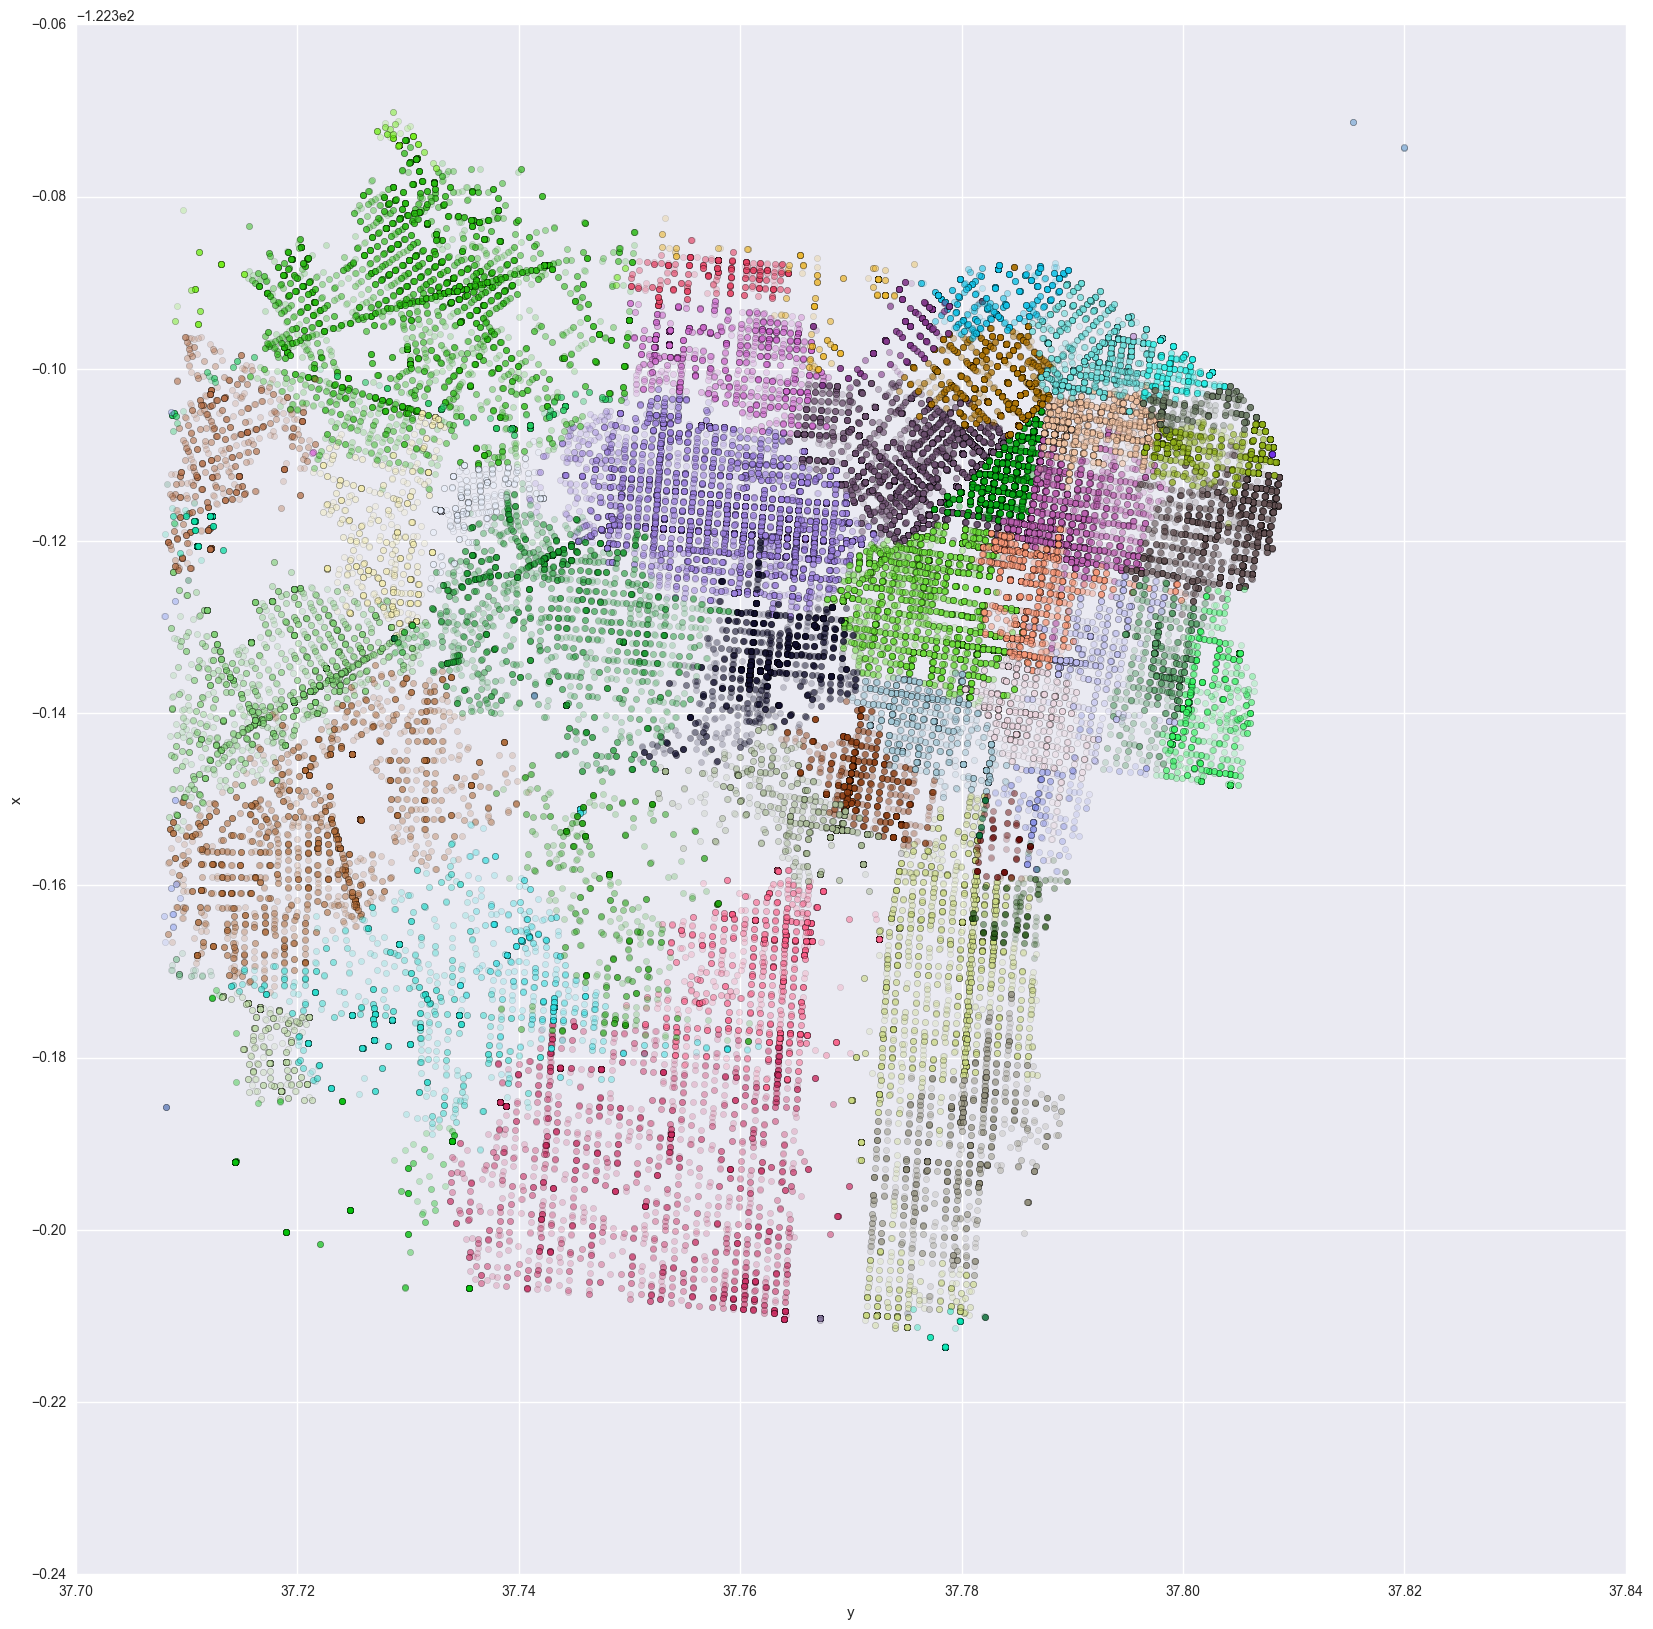

In [7]:
ax =plt.gca()
for n in neighborhoods:
    crime2016[crime2016['neighborhood'] == n].plot('y', 'x', kind='scatter', figsize=(20,20),\
                                                   alpha=0.2, c=np.random.rand(3,1), ax=ax)

## More visualizations in work

In [ ]:
import os
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape
import gmplot
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
#more visualization using basemap and shapely
#get the latitude and longitudes boundraries in SF 
shp1 = fiona.open('../map/sf_find_neigh/sf_find_neigh.shp')
boundary = shp1.bounds
boundary

(-122.5148972319999,
 37.708089209000036,
 -122.35698198799992,
 37.83239597600004)

## Kernell dead everytime tried to run the codes, it works on Friday, but later it always becomes dead after running the Basemap codes. Will try more times

In [ ]:
#SF basemap
m = Basemap(projection='merc', llcrnrlat=37.708089209,urcrnrlat=37.832395976,\
            llcrnrlon=-122.514897231,urcrnrlon=-122.3569819879)
#m.drawcounties()
m.readshapefile(
    'SF',
    color='none',
    zorder=2)

In [5]:
crime2016_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
crime2016_map['area_m'] = crime2016_map['poly'].map(lambda x: x.area)
crime2016_map['area_km'] = crime2016_map['area_m'] / 100000
# Draw neighborhoods with polygons
crime2016_map['patches'] = crime2016_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))

NameError: name 'm' is not defined

In [20]:
#make points in the basemap based on crime incidents' logitudes and latitudes
def makePoints(location):
    map_points = pd.Series([crime2016_map(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(crime2016_map['Longitude'],crime2016_map['Latitude'])])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(crime2016_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

In [26]:
sf_morning_crimes = crime2016[crime2016.morning == 1]
sf_afternoon_crimes = crime2016[crime2016.afternoon == 1]
sf_night_crimes = crime2016[crime2016.night == 1]

In [28]:
sf_afternoon_crimes.head(1)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address_x,x,...,hour,day,month,year,morning,afternoon,night,auto_theft_morning,auto_theft_afternoon,auto_theft_night
4,166102358,larceny/theft,grand theft from locked auto,thursday,05/05/2016,12:30,northern,none,gough st / union st,-122.427271,...,12,5,5,2016,0,1,0,0,1,0
